In [65]:
import pandas as pd


In [66]:
medical_reports = pd.read_csv('reports_copy.csv')

In [67]:
medical_reports.dropna()

,medical_specialty,report
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."
...,...,...
2174,Cardiovascular / Pulmonary,"INDICATION: , Chest pain.,TYPE OF TEST: , Aden..."
2175,Cardiovascular / Pulmonary,"CHIEF COMPLAINT: , Chest pain.,HISTORY OF PRES..."
2176,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , The patient is a..."
2177,Cardiovascular / Pulmonary,"HISTORY OF PRESENT ILLNESS: , Mr. ABC is a 60-..."


In [68]:
grouped_data = medical_reports.groupby('medical_specialty').sample(110,random_state=42)

In [69]:
val_test_data = grouped_data.groupby('medical_specialty').sample(10,random_state=42)

In [70]:
val = val_test_data.groupby('medical_specialty').head(5)
test = val_test_data.groupby('medical_specialty').tail(5)

In [71]:
train = grouped_data[~grouped_data.index.isin(val_test_data.index)]

In [72]:
len(train)

500

In [73]:
train

,medical_specialty,report
2135,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSES:,1. Lumbar osteomyelit..."
1841,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSES:,1. Non-small-cell car..."
1823,Cardiovascular / Pulmonary,"PROCEDURE: , Urgent cardiac catheterization wi..."
2122,Cardiovascular / Pulmonary,"PROCEDURE:, Left Cardiac Catheterization, Lef..."
2047,Cardiovascular / Pulmonary,"EXAM: , Coronary artery CTA with calcium scori..."
...,...,...
700,Surgery,"HISTORY OF PRESENT ILLNESS:, Briefly, this is..."
74,Surgery,"PREOPERATIVE DIAGNOSIS: ,Thyroid goiter with ..."
470,Surgery,"PREOPERATIVE DIAGNOSIS:,1. Cholelithiasis.,2...."
880,Surgery,"PREOPERATIVE DIAGNOSIS: , Cataract, left eye.,..."


In [74]:
pip install --upgrade openai

In [75]:
!pip install tiktoken
import tiktoken

encoder = tiktoken.encoding_for_model("gpt-3.5") #works
#encoder2 = tiktoken.get_encoding("gpt-3.6") #works
#and
#assert encoder.encode("Hi") == encoder2.encode("Hi")
#and
#assert encoder.name == "gpt-3.6"

In [76]:
def num_tokens_from_string(string):
    #encoding = tiktoken.get_encoding('cl100K_base')

    num_tokens = len(encoder.encode(string))
    return num_tokens

In [77]:
report_lengths = train['report'].apply(num_tokens_from_string)

In [78]:
report_lengths.sum()

337394

In [79]:
price_model = 0.008

In [80]:
price_per_epoch = 337394*0.008/1000


In [81]:
price_per_epoch

2.699152

In [82]:
train ['medical_specialty'].unique()

array(['Cardiovascular / Pulmonary', 'Gastroenterology', 'Neurology',
       'Radiology', 'Surgery'], dtype=object)

In [83]:
system_prompt = "Given the medical description report, classify it into one of these categories: "+\
"Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery"

In [84]:
print(system_prompt)

Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery


In [85]:
sample_prompt = {"messages": [{'role': 'system', 'content': system_prompt}, {'role': 'user', 'content': train['report'].iloc[0]}, {'role': 'assistant', 'content': train['medical_specialty'].iloc[0]}]}

In [86]:
print(sample_prompt)

{'messages': [{'role': 'system', 'content': 'Given the medical description report, classify it into one of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology, Radiology, Surgery'}, {'role': 'user', 'content': "PREOPERATIVE DIAGNOSES:,1.  Lumbar osteomyelitis.,2.  Need for durable central intravenous access.,POSTOPERATIVE DIAGNOSES:,1.  Lumbar osteomyelitis.,2.  Need for durable central intravenous access.,ANESTHESIA:,  General.,PROCEDURE:,  Placement of left subclavian 4-French Broviac catheter.,INDICATIONS:  ,The patient is a toddler admitted with a limp and back pain, who was eventually found on bone scan and septic workup to have probable osteomyelitis of the lumbar spine at disk areas.  The patient needs prolonged IV antibiotic therapy, but attempt at a PICC line failed.  She has exhausted most of her easy peripheral IV access routes and referral was made to the Pediatric Surgery Service for Broviac placement.  I met with the patient's mom.  With the help of 

In [87]:
def df_to_format(df):
  formatted_data = []

  for index, row in df.iterrows():
    entry =  {"messages": [{'role': 'system', 'content': system_prompt},{'role': 'user', 'content': row['report']},{'role': 'assistant', 'content': row['medical_specialty']}]}

    formatted_data.append(entry)

  return formatted_data


In [88]:
data = df_to_format(train)

In [89]:
#data[10]

In [90]:
import json

In [91]:
with open('fine_tune_data.jsonl', 'w') as f:
    for entry in data:
        f.write (json.dumps(entry))
        f.write('\n')

In [92]:
val_data = df_to_format(val)

In [93]:
with open ('fine_tuning_data_val.jsonl', 'w') as f:
    for entry in val_data:
        f.write (json.dumps(entry))
        f.write('\n')

In [94]:
import os

In [95]:
!pip install openai

In [96]:
import openai
openai.api_key = "sk-proj-Sc3olp7mHfpXV1W4kNMrT3BlbkFJTm8rZBzUC8fX5O8uDFhH"
openai.organization = "org-lmBQOOgOFLrcN4I8wdfTO6Vh"

In [97]:
file_upload_response = openai.files.create(
    file=open('fine_tuning_data.jsonl', 'rb'),
    purpose='fine-tune'
)

In [98]:
file_upload_response

FileObject(id='file-ldXTP2I7TBIstkg1WoAAWKLS', bytes=1542622, created_at=1718875860, filename='fine_tuning_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [99]:
file_upload_response_val = openai.files.create(
    file=open('fine_tuning_data_val.jsonl', 'rb'),
    purpose='fine-tune'
)

In [100]:
file_upload_response_val

FileObject(id='file-t38eJKZpQJDCcEH1JWRnoImx', bytes=101434, created_at=1718875861, filename='fine_tuning_data_val.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [101]:
openai.files.retrieve(file_upload_response.id)

FileObject(id='file-ldXTP2I7TBIstkg1WoAAWKLS', bytes=1542622, created_at=1718875860, filename='fine_tuning_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [102]:
file_upload_response_val = openai.files.create(
  file=open("fine_tuning_data_val.jsonl", "rb"),
  purpose='fine-tune'
)


In [103]:
openai.files.retrieve(file_upload_response_val.id)

FileObject(id='file-XMNq76OXcfg3hUoQHrwI9gte', bytes=101434, created_at=1718875861, filename='fine_tuning_data_val.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [104]:
fine_tuning_response = openai.fine_tuning.jobs.create(training_file=file_upload_response.id,
                            model="gpt-3.5-turbo",
                            hyperparameters={"n_epochs": 1},
                            validation_file = file_upload_response_val.id)

In [105]:
fine_tuning_response.id

'ftjob-7lLfw6TtEukq60YdKfu6o3cF'

In [106]:
openai.fine_tuning.jobs.list(limit=10)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-7lLfw6TtEukq60YdKfu6o3cF', created_at=1718875864, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-lmBQOOgOFLrcN4I8wdfTO6Vh', result_files=[], seed=480889382, status='validating_files', trained_tokens=None, training_file='file-ldXTP2I7TBIstkg1WoAAWKLS', validation_file='file-XMNq76OXcfg3hUoQHrwI9gte', estimated_finish=None, integrations=[], user_provided_suffix=None), FineTuningJob(id='ftjob-BLtcyK5XkICX7IS0fXyAL4dc', created_at=1718875155, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-lmBQOOgOFLrcN4I8wdfTO6Vh', r

In [107]:
train_event = openai.fine_tuning.jobs.list_events(fine_tuning_job_id="ftjob-BLtcyK5XkICX7IS0fXyAL4dc", limit=10)
train_event.data

[FineTuningJobEvent(id='ftevent-3HffeVF781Ny32tAGCGeObT0', created_at=1718875859, level='info', message='Step 185/500: training loss=0.00', object='fine_tuning.job.event', data={'step': 185, 'train_loss': 1.144409225162235e-06, 'total_steps': 500, 'train_mean_token_accuracy': 1.0}, type='metrics'),
 FineTuningJobEvent(id='ftevent-7auEQfWEwqLgxdLfwxoiFX4C', created_at=1718875856, level='info', message='Step 184/500: training loss=3.95', object='fine_tuning.job.event', data={'step': 184, 'train_loss': 3.951199531555176, 'total_steps': 500, 'train_mean_token_accuracy': 0.75}, type='metrics'),
 FineTuningJobEvent(id='ftevent-Y93McNAJEuTR9aLON0f4cyIH', created_at=1718875854, level='info', message='Step 183/500: training loss=2.41', object='fine_tuning.job.event', data={'step': 183, 'train_loss': 2.40549898147583, 'total_steps': 500, 'train_mean_token_accuracy': 0.75}, type='metrics'),
 FineTuningJobEvent(id='ftevent-6bNNTxiLDIv1RC00mywF8Q0i', created_at=1718875852, level='info', message='St

In [108]:
train_loss = []
val_loss = []
train_acc = []
val_acc = []
for item in train_event.data:
    train_data = item.data
    if train_data and "train_loss" in train_data:

        # As the event list returns the most current event at first, we don't want to append but insert
        train_loss.insert(0, train_data["train_loss"])
        #val_loss.insert(0, train_data["valid_loss"])
        train_acc.insert(0, train_data["train_mean_token_accuracy"])
        #val_acc.insert(0, train_data["valid_mean_token_accuracy"])

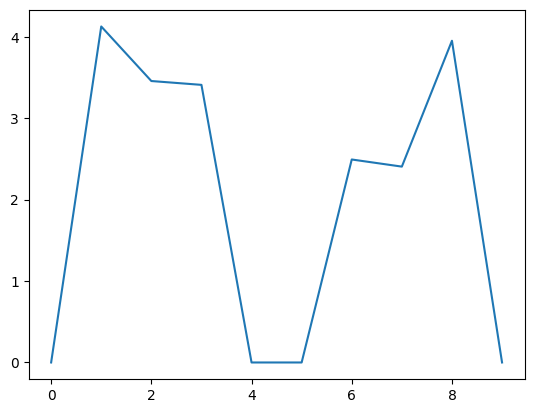

In [109]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_loss)
#plt.plot(val_loss)

In [110]:
test["report"].iloc[1]

'INDICATIONS: , The patient is a 22-year-old female with past medical history of syncope.  The patient is also complaining of dizziness.  She was referred here by Dr. X for tilt table.,TECHNIQUE: , Risks and benefits explained to the patient.  Consent obtained.  She was lying down on her back for 20 minutes and her blood pressure was 111/75 and heart rate 89.  She was standing up on the tilt tablet for 20 minutes and her heart rate went up to 127 and blood pressure was still in 120/80.  Then, the patient received sublingual nitroglycerin 0.4 mg.  The patient felt dizzy at that time and heart rate was in the 120 and blood pressure was 110/50.  The patient felt nauseous and felt hot at that time.  She did not pass out.,COMPLICATIONS:,  None.,Tilt table was then terminated.,SUMMARY:,  Positive tilt table for vasovagal syncope with significant increase of heart rate with minimal decrease of blood pressure.,RECOMMENDATIONS: , I recommend followup in the office in one week and she will need 

In [113]:
completion = openai.chat.completions.create(
    model = "gpt-3.5-turbo",
  messages=[
    {"role": "system", "content": system_prompt},
    {"role": "user", "content": test["report"].iloc[1]}
  ]
)
print(completion.choices[0].message)

ChatCompletionMessage(content='Cardiovascular / Pulmonary', role='assistant', function_call=None, tool_calls=None)


In [114]:
test["medical_specialty"].iloc[1]

'Cardiovascular / Pulmonary'

In [118]:
def classify_report(report):
    completion = openai.chat.completions.create(
                    #model = "ft:gpt-3.5-turbo-0125:personal::9al2gCXA",
                    model = "gpt-3.5-turbo",
                    messages=[
                            {"role": "system", "content": system_prompt},
                            {"role": "user", "content": report}
                          ]
                        )
    return completion

In [116]:
test

,medical_specialty,report
2016,Cardiovascular / Pulmonary,"CLINICAL INDICATION:, Chest pain.,INTERPRETAT..."
1833,Cardiovascular / Pulmonary,"INDICATIONS: , The patient is a 22-year-old fe..."
1932,Cardiovascular / Pulmonary,"REASON FOR CONSULTATION: , Loculated left effu..."
1949,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSIS:, Right middle lobe lu..."
1847,Cardiovascular / Pulmonary,"POSTOPERATIVE DIAGNOSIS: , Type 4 thoracoabdom..."
1639,Gastroenterology,"PREOPERATIVE DIAGNOSIS:,1. Cholelithiasis.,2...."
1735,Gastroenterology,"EXAM: , CT of the abdomen and pelvis without c..."
1781,Gastroenterology,"REASON FOR CONSULTATION: , I was asked by Dr. ..."
1670,Gastroenterology,"DIAGNOSIS ON ADMISSION: , Gastrointestinal ble..."
1776,Gastroenterology,"PROCEDURE:, Colonoscopy.,PREOPERATIVE DIAGNOS..."


In [119]:
predicted_classes = []
ground_truth_classes = []
for line in test.iterrows():
    report, specialty = line[1]["report"], line[1]["medical_specialty"]
    ground_truth_classes.append(specialty.strip())  # in case of any trailing
    prediction = classify_report(report)
    predicted_classes.append(prediction.choices[0].message.content.strip())


In [120]:
import numpy as np

In [121]:
(np.array(predicted_classes) == np.array(ground_truth_classes)).mean()

0.28

In [122]:
predicted_classes

['Category: Cardiovascular / Pulmonary',
 'This medical report falls under the category of Cardiovascular / Pulmonary.',
 'This medical description report falls under the category of Pulmonary.',
 'Category: Surgery',
 'This medical report falls under the category of **Surgery**.',
 'This medical report falls under the category of Surgery.',
 'Gastroenterology',
 'Gastroenterology',
 'Gastroenterology',
 'Gastroenterology',
 'This medical description report falls under the category of Neurology.',
 'Neurology',
 'This medical description report falls under the category of Neurology.',
 'Neurology',
 'Category: Surgery',
 'This medical description report falls under the category of Radiology.',
 'Gastroenterology',
 'Neurology',
 'This medical report falls under the category of Cardiovascular / Radiology.',
 'This medical report falls under the category of Neurology.',
 'This medical description report falls under the category of Cardiology.',
 'Cardiovascular / Pulmonary',
 'Surgery',


In [123]:
ground_truth_classes

['Cardiovascular / Pulmonary',
 'Cardiovascular / Pulmonary',
 'Cardiovascular / Pulmonary',
 'Cardiovascular / Pulmonary',
 'Cardiovascular / Pulmonary',
 'Gastroenterology',
 'Gastroenterology',
 'Gastroenterology',
 'Gastroenterology',
 'Gastroenterology',
 'Neurology',
 'Neurology',
 'Neurology',
 'Neurology',
 'Neurology',
 'Radiology',
 'Radiology',
 'Radiology',
 'Radiology',
 'Radiology',
 'Surgery',
 'Surgery',
 'Surgery',
 'Surgery',
 'Surgery']

In [124]:
import time
from tqdm.notebook import tqdm

def classify_report_baseline(report):
    try:
        completion = openai.chat.completions.create(
                        model = "gpt-3.5-turbo",
                        messages=[
                                {"role": "system", "content": system_prompt},
                                {"role": "user", "content": report}
                              ],
                        temperature=0
                            )
    except openai.error.APIConnectionError:  # To retry if openai loses the connection
        time.sleep(10)
        completion = openai.chat.completions.create(
                model = "gpt-3.5-turbo",
                messages=[
                        {"role": "system", "content": system_prompt},
                        {"role": "user", "content": report}
                      ],
                temperature=0
                    )

    return completion

In [125]:
predicted_classes = []
ground_truth_classes = []
for line in tqdm(test.iterrows()):
    report, specialty = line[1]["report"], line[1]["medical_specialty"]
    ground_truth_classes.append(specialty.strip())  # in case of any trailing
    prediction = classify_report_baseline(report)
    predicted_classes.append(prediction.choices[0].message.content.strip())


0it [00:00, ?it/s]

In [126]:
(np.array(predicted_classes) == np.array(ground_truth_classes)).mean()

0.28